In [1]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


Hamming Distance =  0.0


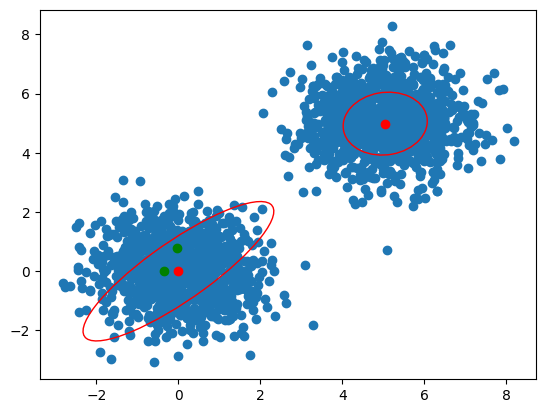

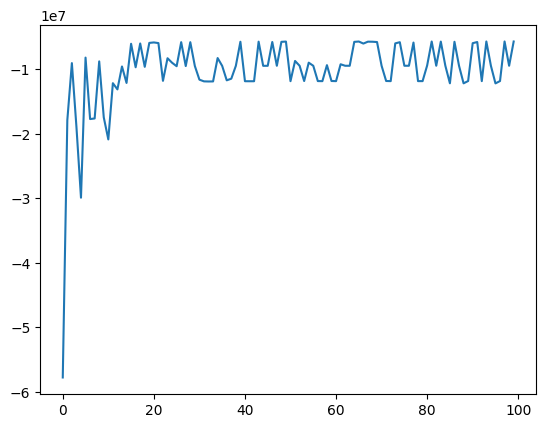

In [2]:
#batch 700 - 300 it
test_hmmbatchsgd()

True
terminated early - convergence, 
 elbo : -1436754.420849709 
 lower bound : -1436754.420849709
allclose  = True, diff : 0.0
Hamming Distance =  0.0


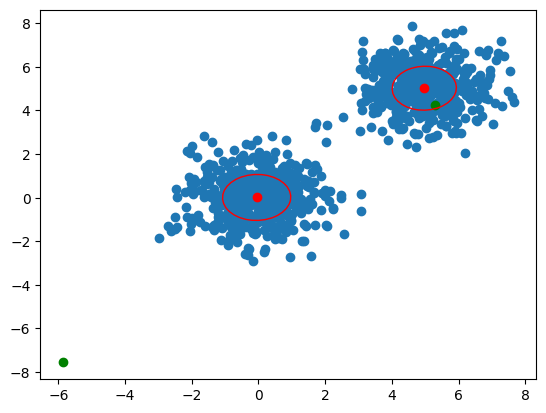

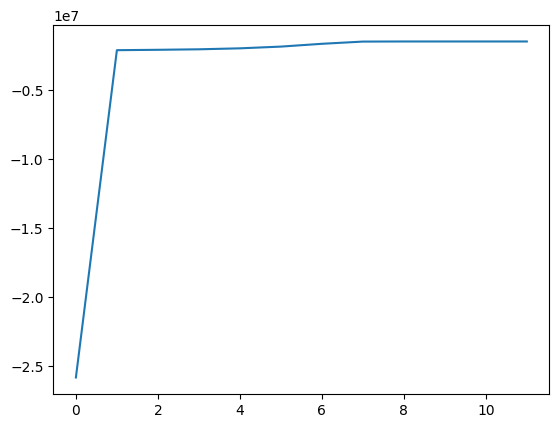

In [4]:
#batch 1 - 200 it

test_hmmbatchcd()

Hamming Distance =  0.499


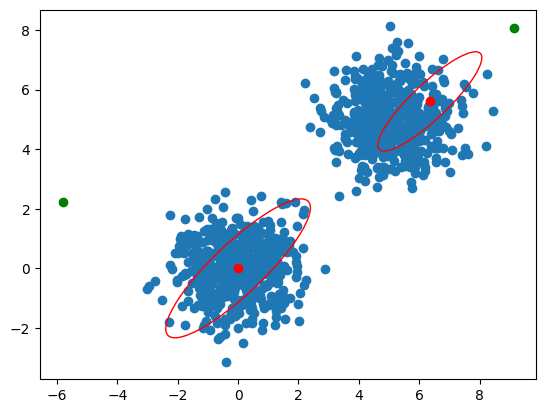

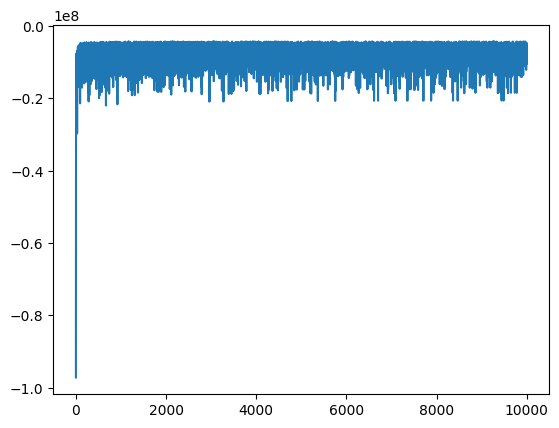

In [4]:
#batch 1 - 10000 it

test_hmmbatchsgd()

Hamming Distance =  0.499


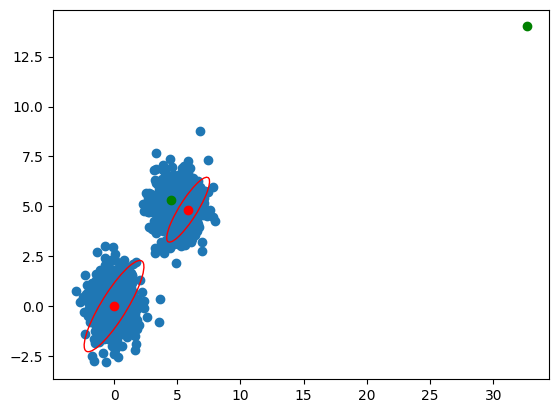

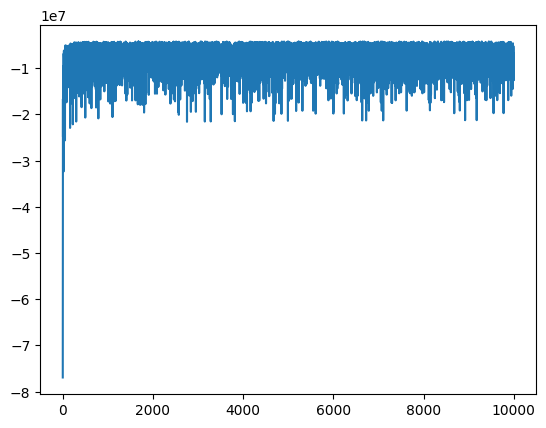

In [5]:
#batch 1 - 10000 it

test_hmmbatchsgd()

Hamming Distance =  0.0


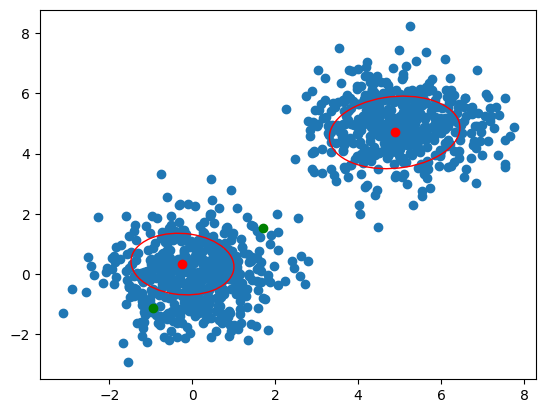

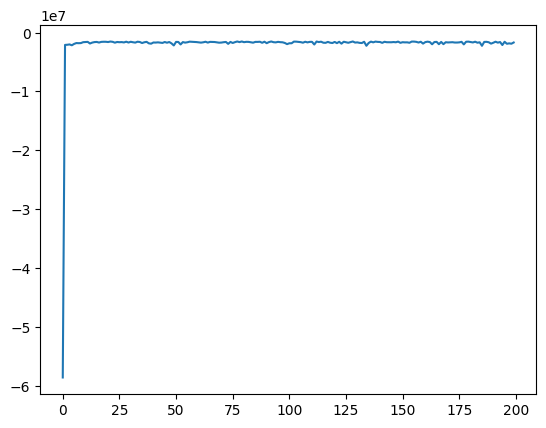

In [8]:
#batch 20 - 200 it
test_hmmbatchsgd()

terminated early - convergence
Hamming Distance =  0.0


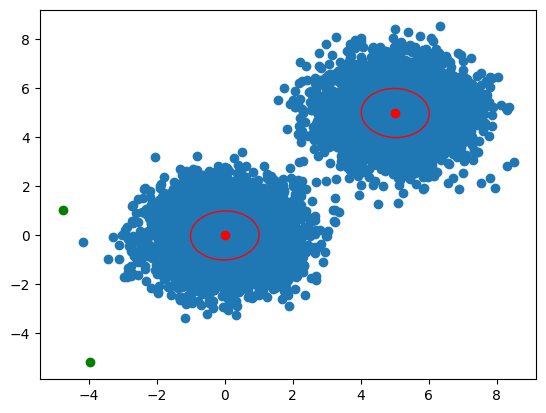

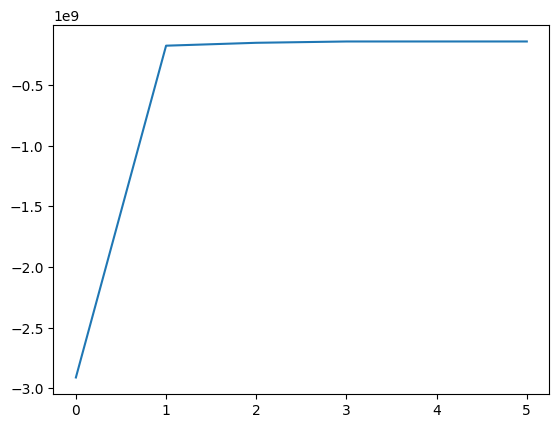

In [4]:
test_hmmbatchcd()

In [6]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchsgd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


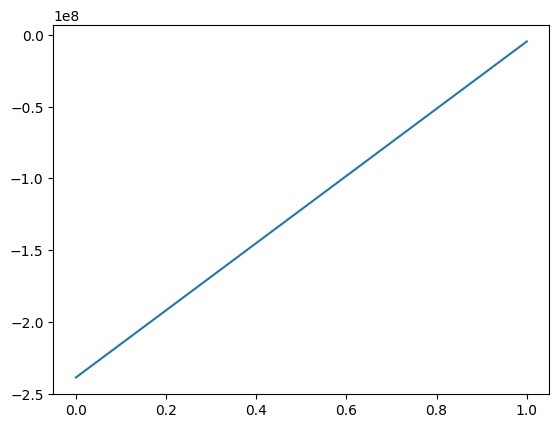

In [11]:
plt.plot(elbo)

In [12]:
elbo

array([-2.38592301e+08, -4.62848252e+06])

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


Hamming Distance =  0.0236


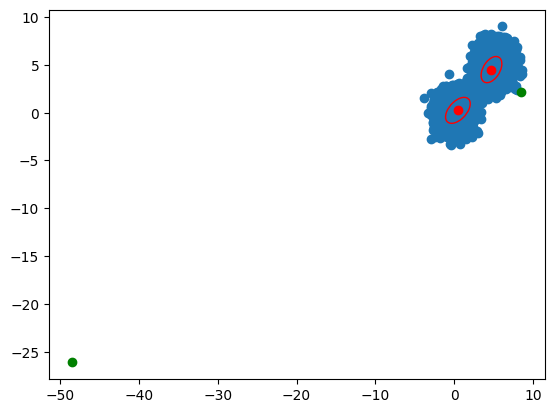

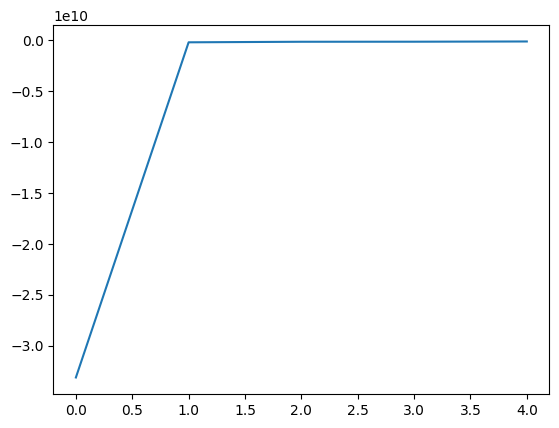

terminated early - convergence
Hamming Distance =  0.0


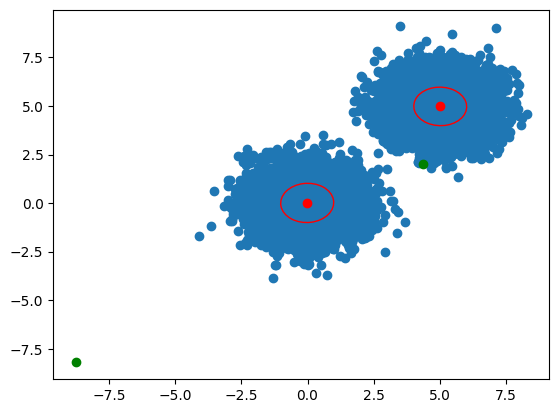

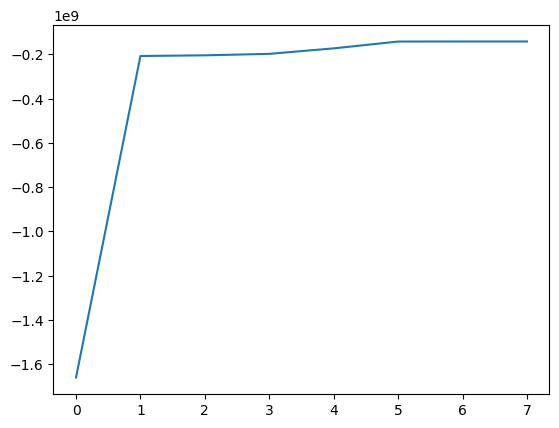

In [1]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import time

# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd()
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time

In [2]:
print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

test_hmmbatchsgd() took 1.00 seconds to run
test_hmmbatchcd() took 1.54 seconds to run


Hamming Distance =  0.0


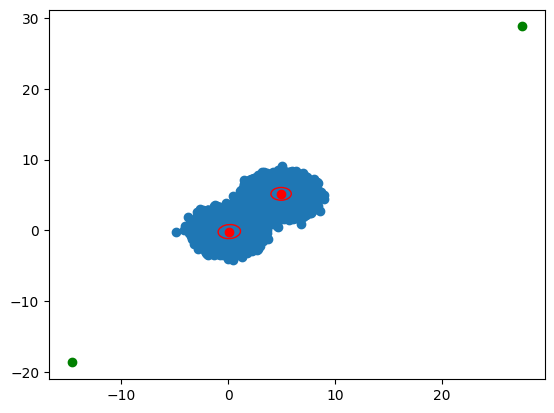

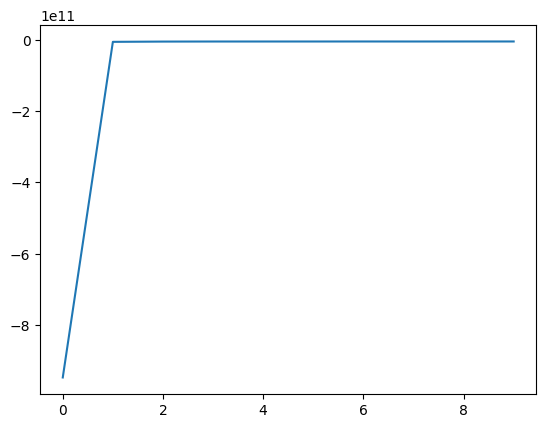

terminated early - convergence
Hamming Distance =  0.0


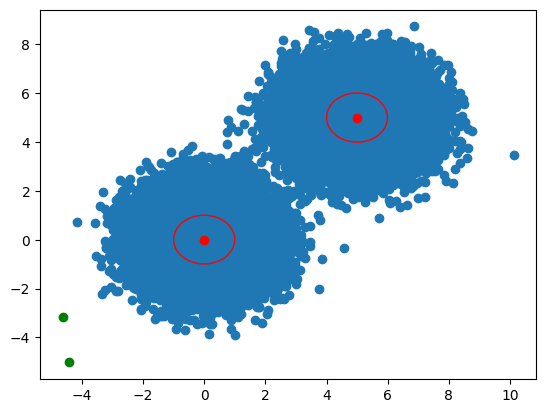

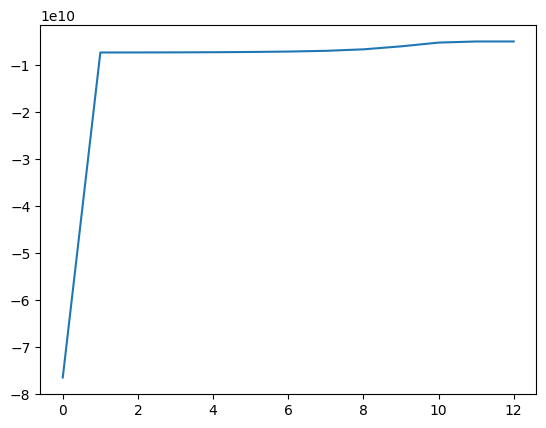

test_hmmbatchsgd() took 6.93 seconds to run
test_hmmbatchcd() took 9.84 seconds to run


In [4]:
#60000 10 maxit 96 batch
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import time

# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd()
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time

print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


Hamming Distance =  0.0


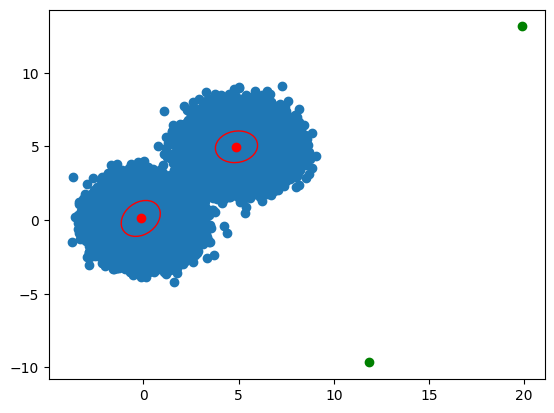

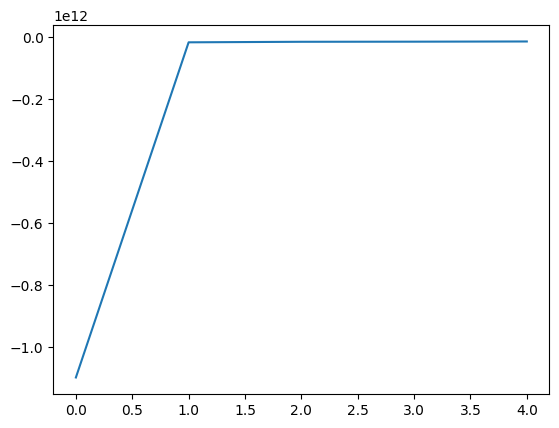

In [1]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import time

test_hmmbatchsgd()